In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [4]:
directories = {
    'flail': '/kaggle/input/chestpelviscspinescans/chest_flail',
    'hemothorax': '/kaggle/input/chestpelviscspinescans/chest_hemothorax',
    'normal': '/kaggle/input/chestpelviscspinescans/chest_normal',
    'pneumothorax': '/kaggle/input/chestpelviscspinescans/chest_pneumothorax'
}

# Load and shuffle image paths and labels
image_paths = []
labels = []
for category, directory_path in directories.items():
    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg'))]
    image_paths.extend([os.path.join(directory_path, file) for file in image_files])
    labels.extend([category] * len(image_files))

In [5]:
indices = np.arange(len(image_paths))
np.random.shuffle(indices)

shuffled_image_paths = []
shuffled_labels = []

for index in indices:
    image_path = image_paths[index]
    label = labels[index]

    image = Image.open(image_path)
    image = image.resize((224, 224), Image.BILINEAR)

    image_array = np.array(image)

    shuffled_image_paths.append(image_array)
    shuffled_labels.append(label)

X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)

In [6]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [7]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [8]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)



9406464/9406464 [==============================] - 0s 0us/step


In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)


In [9]:
history = model.fit(
    image_generator.flow(X_train, Y_train_encoded, batch_size=32),
    validation_data=image_generator.flow(X_val, Y_val_encoded),
    epochs=50,
)

Epoch 1/50
49/49 [==============================] - 29s 388ms/step - loss: 0.9875 - accuracy: 0.5853 - val_loss: 0.8719 - val_accuracy: 0.6462
Epoch 2/50
49/49 [==============================] - 18s 363ms/step - loss: 0.7008 - accuracy: 0.7199 - val_loss: 0.6830 - val_accuracy: 0.7333
Epoch 3/50
49/49 [==============================] - 17s 349ms/step - loss: 0.6287 - accuracy: 0.7532 - val_loss: 0.6054 - val_accuracy: 0.7692
Epoch 4/50
49/49 [==============================] - 18s 365ms/step - loss: 0.5454 - accuracy: 0.7968 - val_loss: 0.5192 - val_accuracy: 0.7744
Epoch 5/50
49/49 [==============================] - 18s 362ms/step - loss: 0.4949 - accuracy: 0.8141 - val_loss: 0.5313 - val_accuracy: 0.8205
Epoch 6/50
49/49 [==============================] - 17s 353ms/step - loss: 0.4600 - accuracy: 0.8282 - val_loss: 0.4819 - val_accuracy: 0.8205
Epoch 7/50
49/49 [==============================] - 18s 364ms/step - loss: 0.4342 - accuracy: 0.8417 - val_loss: 0.5147 - val_accuracy: 0.7795

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 0s 28ms/step - loss: 0.2753 - accuracy: 0.8974
Test Accuracy: 89.74%


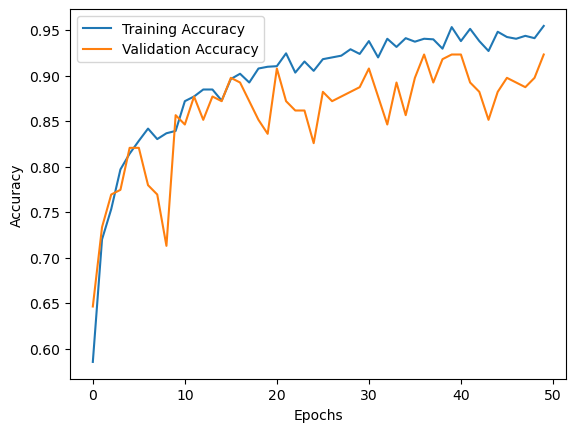

In [11]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

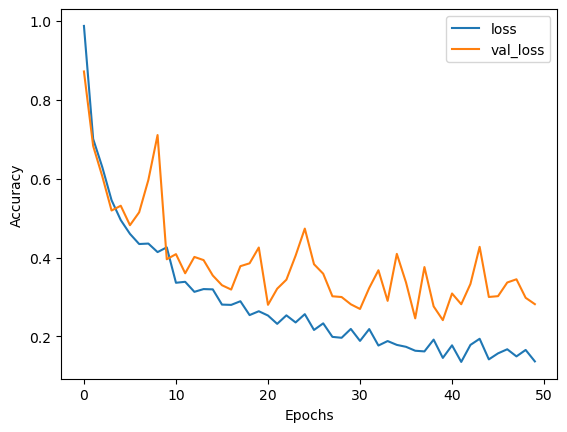

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


7/7 [==============================] - 8s 1s/step


In [11]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [24]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       flail       0.91      1.00      0.95        48
  hemothorax       1.00      0.78      0.88        46
      normal       0.88      1.00      0.93        49
pneumothorax       0.94      0.90      0.92        52

    accuracy                           0.92       195
   macro avg       0.93      0.92      0.92       195
weighted avg       0.93      0.92      0.92       195



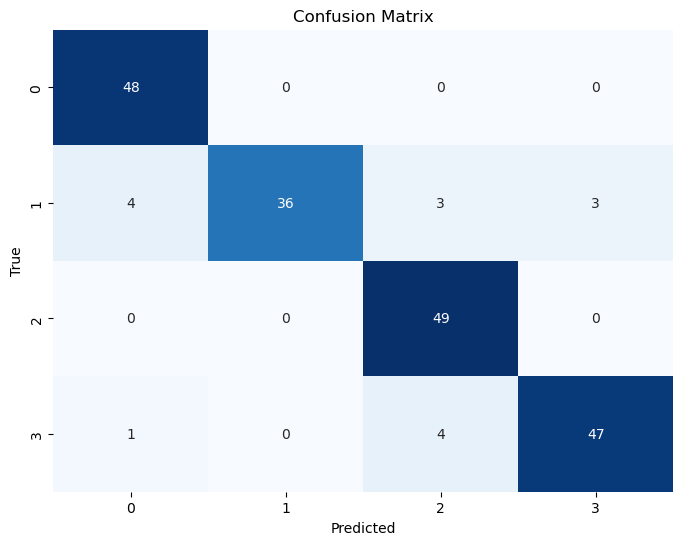

In [26]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

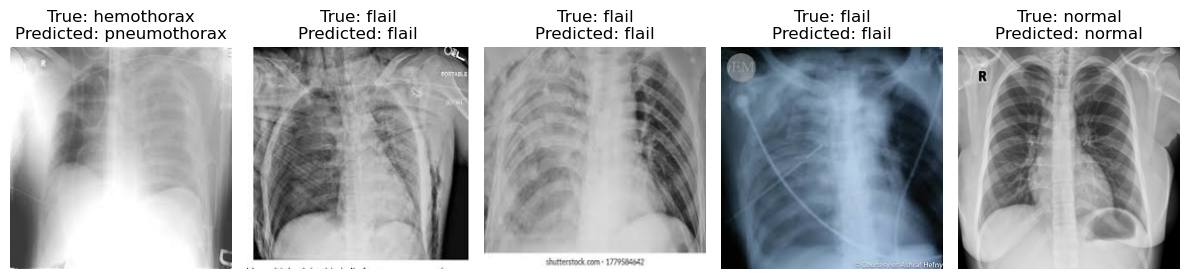

In [17]:
num_images_to_display = 5  
plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
model_filename = "Chest1.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

Model saved as Chest1.h5


In [9]:
model = tf.keras.models.load_model("Chest1.h5")

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    cam = cv2.resize(cam.numpy(), (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())  

    return cam 

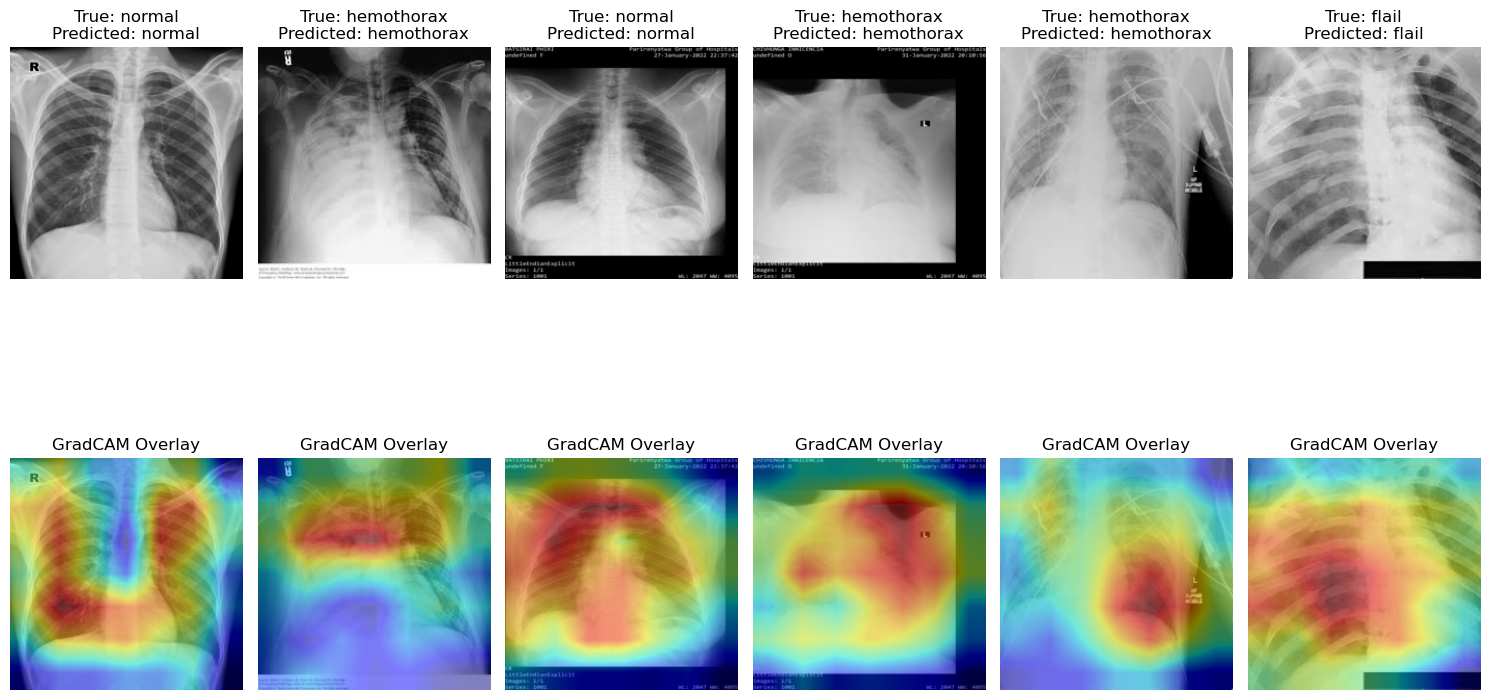

In [22]:
layer_name = 'Conv_1'
num_images_to_display = 6  

plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img = X_test[i]

    img = (img * 255).astype(np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    img_array = preprocess_input(np.expand_dims(img, axis=0))  
    cam = compute_gradcam(model, img_array, layer_name)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(img, cmap='viridis') 
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')

    plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(img, cmap='viridis')  
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title('GradCAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()